Observed
-----
Talk about qdpi and how you build the alleles from sequencing data and also the truth dataset.

Make the low/medium/high vaf bins and the curves

Do it again with the ultra-low separated.

Talk about how these curves have a pattern and you can imagine, well, if we had higher coverage, wouldn't the proportion which are supported increase?

Move into beta binomial distribution (you can do just a bernolli trial, but that doesn't work for whatever reasons.

Then we can match the observed 'recall' to our model to show it largely holds up.

Detour: Can we update the expected VAF based on the observed coverage? And possibly weigh the recall by the probability. The second one is a little more interesting. Like, can we better approximate how good the recall is based on our modeling? Like, if we see that of the 100 sites with VAF of 0.1, the 100x coverage says 67% of them should be supported by ≥8. If the tool is only finding 40%, then we know that there is something off about the caller.

Just a simple score can work where we measure the observed / expected percents. if it's 1, it's doing fine, > better and < worse than what's possible. If we then put our min_reads at something like 5, but allow the tools to report as little as 1 read, we can then get an idea of the tools ability to handle super low coverage.


In [3]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

full_data = pd.read_csv("../../allele_delta/training_data.csv")
measure = full_data[(full_data['expected_len'].abs() >= 50)
            & (full_data['observed_vaf'] != 0)
           ].sample(5000, random_state=20)

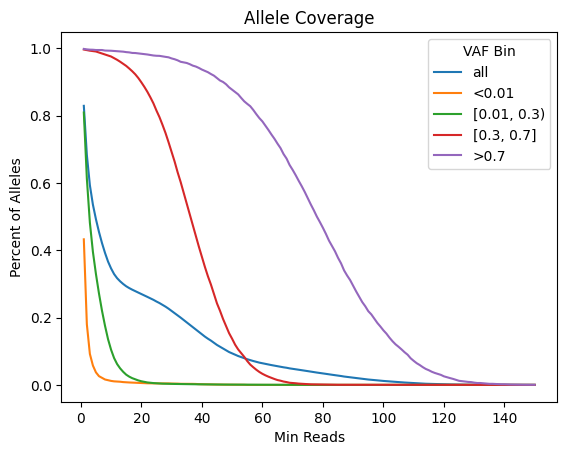

In [5]:
measure = full_data
subset = measure['expected_len'].abs() >= 50
hyper_low = measure['expected_vaf'] < 0.01
low = measure['expected_vaf'].between(0.01, 0.30, inclusive='left')
medium = measure['expected_vaf'].between(0.30, 0.70)
high = measure['expected_vaf'] > 0.70

def foo(x, min_reads, name):
    tp = (x['read_count'] >= min_reads).sum()
    total = len(x)
    fn = total - tp
    return [tp, fn, total, tp/total, min_reads, name]

rows = []
for name, df in [('all', subset), ('<0.01', hyper_low), ('[0.01, 0.3)', low), ('[0.3, 0.7]', medium), ('>0.7', high)]:
    view = measure[subset & df]
    for cov_x in range(1, 151):
        rows.append(foo(view, cov_x, name))
    
r = pd.DataFrame(rows, columns=['TP', 'FN', 'total', 'recall', "min reads", "VAF Bin"])

p = sb.lineplot(data=r, x="min reads", y="recall", hue='VAF Bin')
_ = p.set(ylabel="Percent of Alleles", xlabel="Min Reads", title="Allele Coverage")

In [17]:
view = r[r['min reads'] <= 5]
view = view.melt(id_vars = ['min reads', 'VAF Bin'], value_vars=['recall'])
(view.groupby(['min reads', 'VAF Bin'])['value'].mean().unstack() * 100).round(1)

VAF Bin,<0.01,>0.7,"[0.01, 0.3)","[0.3, 0.7]",all
min reads,,,,,
1,43.3,99.8,80.9,99.7,82.9
2,18.0,99.7,61.3,99.5,68.4
3,9.2,99.6,48.2,99.3,59.3
4,5.8,99.6,39.6,99.2,53.6
5,3.7,99.5,33.0,99.1,49.3


In [156]:
import math
import numpy as np
import scipy.special as sp
import scipy.integrate as integrate

to_analyze = measure[subset]

def binomial_probability(vaf, coverage, min_reads):
    prob = 0
    for i in range(0, min_reads):
        binom_coeff = math.comb(coverage, i)
        prob += binom_coeff * (vaf ** i) * ((1 - vaf) ** (coverage - i))
    return 1 - prob

def beta_binomial_probability(vaf, coverage, min_reads):
    prob = 0
    alpha = coverage * vaf + 1
    beta = coverage * (1-vaf) + 1
    beta_term2 = sp.beta(alpha, beta)
    for k in range(0, min_reads):
        binom_coeff = sp.comb(coverage, k)
        beta_term1 = sp.beta(k + alpha, coverage - k + beta)
        beta_term = beta_term1 / beta_term2
        prob += binom_coeff * beta_term
    return 1 - prob

def grab_observed(vaf, min_reads):
    d = to_analyze[(to_analyze['expected_vaf'].round(2) == vaf)]
    tot = len(d)
    cov = (d['read_count'] >= min_reads).sum()
    return cov / tot, cov, tot 
                
def make_probs(vafs, coverage=100):
    rows = []
    for v in vafs:
        for k in range(0, coverage):
            obs, gt, cnt  = grab_observed(v, k)
            rows.append([v, k, gt, cnt, obs, 
                         binomial_probability(v, coverage, k), 
                         beta_binomial_probability(v, coverage, k)])
    return pd.DataFrame(rows, columns=['VAF', 'min reads', '≥', 'cnt', 'observed', 'binomial', 'beta_binomial']) 

In [141]:
predicted = make_probs([0.01, 0.05, 0.1, 0.5, 0.99])

In [46]:
view = predicted.melt(id_vars=['VAF', 'min reads'], var_name="Measure", value_name="percent", value_vars=['observed', 'binomial', 'beta_binomial'])

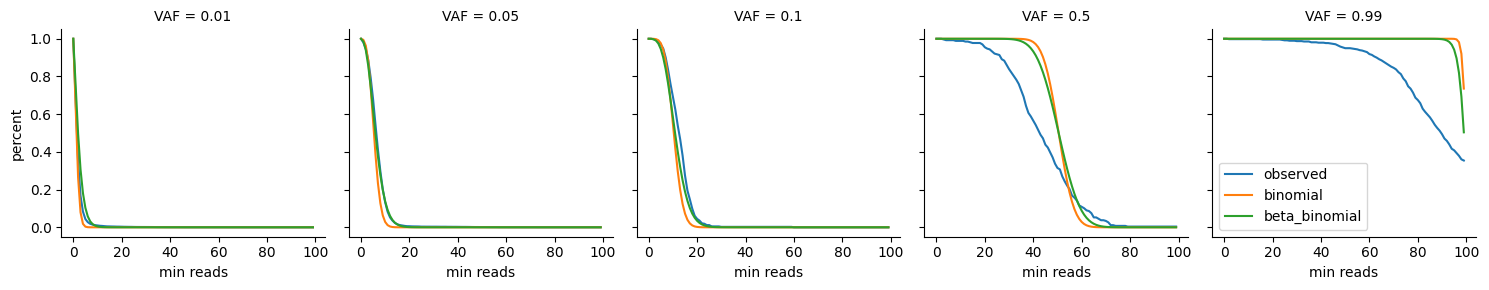

In [50]:
g = sb.FacetGrid(data=view, col='VAF', hue="Measure")
g.map(sb.lineplot, "min reads", "percent")
plt.legend()

In [54]:
from scipy.stats import pearsonr

rows = []
for name, df in predicted.groupby(['VAF']):
    rows.append((name[0], pearsonr(df['observed'], df['binomial']).statistic, 
                pearsonr(df['observed'], df['beta_binomial']).statistic))
corr = pd.DataFrame(rows, columns=['VAF', 'Obs_Bin', 'Obs_BeBin'])

In [55]:
corr

,VAF,Obs_Bin,Obs_BeBin
0,0.01,0.993526,0.986571
1,0.05,0.987237,0.999263
2,0.10,0.981936,0.995190
3,0.50,0.955382,0.966221
4,0.99,0.344257,0.497759


In [175]:
# Let's model the frequency (count) of VAFs in the benchmark. we'll bin them in 0.005 VAFs and get the counts.
# Then we can model the expected recall.
import truvari
data = pd.read_csv("/Users/english/code/smaht/asm_stats/summary.smaht.single.nophab.txt.gz", sep='\t', names=['size', 'VAF', 'AC', 'AF'])
data['vafbin'] = pd.cut(data['VAF'], np.linspace(0, 1, 200))
data['szbin'] = data['size'].apply(lambda x: truvari.get_sizebin(x))

In [176]:
sv_cnts = data[data['size'].abs() >= 50]['vafbin'].value_counts(sort=False)
sv_cnts /= sv_cnts.sum()

In [153]:
cnts = data['vafbin'].value_counts(sort=False)
cnts /= cnts.sum()

In [199]:
beta_binomial_probability(.1, 100, 3)

0.9903200508641924

In [168]:
def vaf_over_range(vaf_min, vaf_max, vaf_values, coverage, min_reads):
    # Calculate the beta-binomial probabilities for each VAF in the empirical data
    probabilities = []
    weights = []
    for vaf, cnt in vaf_values:
        if vaf_min <= vaf < vaf_max:
            probabilities.append(beta_binomial_probability(vaf, coverage, min_reads))
            weights.append(cnt)
    
    # Compute the weighted average of probabilities
    weighted_prob = np.average(probabilities, weights=weights)
    
    return weighted_prob

In [177]:
all_vafs = vafs
vafs = [[_.mid, sv_cnts.loc[_]] for _ in cnts.index]


In [197]:
import json
print(json.dumps(vafs))

[[0.002515, 0.09496850031452742], [0.007565, 0.36352796477293], [0.0126, 0.0179984790017745], [0.0176, 0.03740528969382869], [0.022600000000000002, 0.006985325183787285], [0.02765, 0.006900825282370504], [0.0327, 0.0024692748969570646], [0.0377, 0.0011829986198349436], [0.0427, 0.0007980546244918269], [0.04775, 0.13992244786825528], [0.0528, 0.004271939460515074], [0.057800000000000004, 0.031208630256598036], [0.0628, 0.004300106094320667], [0.06785, 0.010891098404829639], [0.07289999999999999, 0.0031922184979673077], [0.0779, 0.003699217906467998], [0.0829, 0.0020092198781323646], [0.08795, 0.0014740538358260803], [0.093, 0.00101399881700138], [0.09825, 0.005614549005248382], [0.10350000000000001, 0.000779276868621431], [0.1085, 0.003117107474485724], [0.1135, 0.001032776572871776], [0.1185, 0.0021594419250955317], [0.1235, 0.0008731656479734107], [0.1285, 0.0012674985212517253], [0.1335, 0.000779276868621431], [0.1385, 0.0007417213568806392], [0.1435, 0.0006478325775286595], [0.1485,

In [193]:
def make_bins(coverage, min_reads):
    print('all %.3f' % (vaf_over_range(0, 1, vafs, coverage, min_reads)))
    print('low %.3f' % (vaf_over_range(0.00, 0.3, vafs, coverage, min_reads)))
    print('medium %.3f' % (vaf_over_range(0.3, 0.7, vafs, coverage, min_reads)))
    print('high %.3f' % (vaf_over_range(0.7, 1, vafs, coverage, min_reads)))

In [194]:
mr = 2
make_bins(100, mr)
print()
make_bins(50, mr)
print()
make_bins(300, mr)

all 0.694
low 0.594
medium 1.000
high 1.000

all 0.606
low 0.476
medium 1.000
high 1.000

all 0.843
low 0.791
medium 1.000
high 1.000


In [180]:
print('all', vaf_over_range(0, 1, vafs, 100, 1))
print('low', vaf_over_range(0.00, 0.3, vafs, 100, 1))
print('medium', vaf_over_range(0.3, 0.7, vafs, 100, 1))
print('high', vaf_over_range(0.7, 1, vafs, 100, 1))

all 0.8381280914665987
low 0.784831391341445
medium 0.9999999999999997
high 1.0


In [181]:
print('all', vaf_over_range(0, 1, vafs, 300, 1))
print('low', vaf_over_range(0.00, 0.3, vafs, 300, 1))
print('medium', vaf_over_range(0.3, 0.7, vafs, 300, 1))
print('high', vaf_over_range(0.7, 1, vafs, 300, 1))

all 0.9329630230560714
low 0.9108909434108241
medium 1.0
high 1.0
